### Metaprogramowanie - skrót z wykładu.
W celu pełnego zrozumienia tematu należy zapoznać się z wykładem.

<b>“code is data and data is code“</b>

Kazdy kawalek kodu jest reprezentowany wewnetrznie jako zwykla struktura danych w Julii (nazywana wyrazeniem - expression) 



### Wyrażenia

In [1]:
# program w Julii mozna wyciagnac z napisu np.:  
prog = "12 + 30"

"12 + 30"

In [2]:
# możemy  zamienić napis na wyrażenie.
ex1 = parse(prog)

:(12 + 30)

In [3]:
typeof(ex1)

Expr

Reprezentacja kodu to typ Expr

```julia
type Expr
 head::Symbol
 args::Array{Any,1}
 typ
end
```

In [4]:
# rodzaj wyrażenia
#mozliwe rodzaje wyrazen http://docs.julialang.org/en/stable/devdocs/ast/
ex1.head

:call

In [5]:
# arguementy
ex1.args

3-element Array{Any,1}:
   :+
 12  
 30  

In [6]:
# typ zwracany
ex1.typ

Any

In [7]:
# wyrażenia możemy tworzyć ręcznie
ex2 = Expr(:call, :+, 12, 30)

:(12 + 30)

In [8]:
ex1==ex2

true

In [9]:
# Drzewo składni abstrakcyjnej (AST - abstract syntax tree)
ex3 = parse("2+a*b-c")
dump(ex3)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol -
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Int64 2
        3: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol *
            2: Symbol a
            3: Symbol b
          typ: Any
      typ: Any
    3: Symbol c
  typ: Any


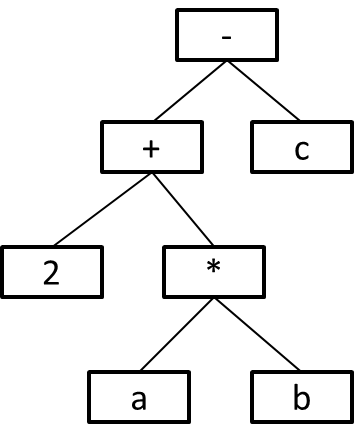

In [10]:
#Drzewo skladni abstrakcyjnej - wizualnie
#wyswietlenie obrazka png wymaga zaistalowania pakietow Pkg.add("Images"); Pkg.add("FileIO")
using Images
using FileIO
img = load("/home/user/drzewo.png")

In [11]:
# to jest to samo
:(a + b*c + 1)  == 
parse("a + b*c + 1") ==
Expr(:call, :+, :a, Expr(:call, :*, :b, :c), 1)

true

### Interpolacja

In [12]:
# wyrazenie nastepujace po $ jest od razu obliczane 
# moze byc uzyta do wygodnego i czytelnego tworzenia wyrażeń
a = 1;
ex = :($a + b)
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Symbol b
  typ: Any


### Ewaluacja

In [13]:
# funkcja eval() wylicza wartosc wyrazenia
ex = :(1+2)
eval(ex)

3

### Makra

Etapy przetwarzania kodu(przypomnienie):
 
 1. zrodla
 2. parsowanie
 3. <b>rozwijanie makr</b>
 4. lowering (@code_lowered) - posrednia reprezentacje kodu  w formie Abstract Syntax Three
 5. type inference - okreslanie typow
 6. inlining - funkcje inline
 7. generated function expansion (@code_typed)
 8. generacja kodu (@code_llvm)
 9. native compilation - do assemblera (@code_native)
 10. RUN
 
  Makra pozwalaja programiscie tworzyc i wstawiac fragmenty kodu przed wykonaniem calosci kodu. 
  
  Makra generalnie  działają na wyrażeniach (mogą też przyjmować symbole i literały jako argumenty) i zwracają wyrażenia

In [14]:
# Przykład: tutaj nie byloby mozliwe napisanie tego jako funkcji myassert(), 
# poniewaz nie moznaby było wypisać zawartości wyrażenia ex, 
# na etapie wykonania funkcji  znamy tylko wartość ex 
# t.j. wiemy,  czy ex jest true/false a nie wiemy że to powstało np. z porównania 1==1.0 .

macro myassert(ex)
    return :($ex ? nothing : error("Assertion failed: ", $(string(ex))))
end

@myassert (macro with 1 method)

In [15]:
@myassert 1==1.0

In [16]:
@myassert 1==0

LoadError: Assertion failed: 1 == 0

In [17]:
# funkcja macroexpand pokazuje w jakie wyrażenie rozwija się makro
macroexpand(:(@myassert(1==1)))

:(if 1 == 1
        nothing
    else 
        error("Assertion failed: ","1 == 1")
    end)

#### Użycie makr do przyspieszania obliczeń - przykład z algorytmem Hornera

Sluzy do obliczania wartosci wielomianow $a_nx^n+a_{n-1}x^{n-1}+ ... +a_0$ 

$ b_n=a_n $

$ b_{n-1}=a_{n-1}+b_nx$

$ b_{n-2}=a_{n-2}+b_{n-1}x$

....

$b_{0}=a_{0}+b_{1}x$

In [18]:
# funkcja wykonuje pętlę przepisaną z algorytmu:
function poly_horner(x, a...)
    b=zero(x)
    for i= length(a):-1:1
        b= a[i] + b * x
    end
    return b
end

poly_horner (generic function with 1 method)

In [19]:
f_horner(x)=poly_horner(x,1,2,3,4,5)

f_horner (generic function with 1 method)

In [20]:
# pomiar czasu i pamięci:
f_horner(1)
using BenchmarkTools
@benchmark f_horner(3.5)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     29.262 ns (0.00% GC)
  median time:      31.781 ns (0.00% GC)
  mean time:        37.090 ns (3.11% GC)
  maximum time:     3.509 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     994
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [21]:
# to makro zwraca wyrażenie - używa pętli, aby wyprodukować ostateczny "wzór" wstawiając wartości
# współczynników wielomianu

# można to zrobić, bo na tym etapie wiadomo, ile razy użyć pętli.
# dzięki temu pętla jest wykonywana tylko raz, na etapie rozwijania makra.

# dygresja: pomocnicza funkcja esc() - wyrażenie jest brane "jak jest", nie jest w zaden sposób przekszalcane 
# przez makro dla celów "hygienic" (więcej na wykładzie)   

macro horner(x, p...)
    ex= esc(p[end])
    for i = length(p)-1:-1:1
         ex= :(muladd(t, $ex, $(esc(p[i]))))
    end
    Expr(:block, :(t=$(esc(x))), ex)
end

@horner (macro with 1 method)

In [22]:
macroexpand(:(@horner(3.5,1,2,3,4,5)))
# dygresja: do zmiennej t został dodany unikalny identyfikator dla celów hygienic (więcej na wykładzie) 

quote 
    #61#t = 3.5
    muladd(#61#t,muladd(#61#t,muladd(#61#t,muladd(#61#t,5,4),3),2),1)
end

In [23]:
f_horner_macro(x)=@horner(x, 1,2,3,4,5)

f_horner_macro (generic function with 1 method)

In [24]:
f_horner_macro(1)

15

In [25]:
#pomiar czasu i pamięci:
@benchmark f_horner_macro(3.5)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.661 ns (0.00% GC)
  median time:      1.718 ns (0.00% GC)
  mean time:        1.829 ns (0.00% GC)
  maximum time:     122.751 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000
  time tolerance:   5.00%
  memory tolerance: 1.00%

### Generated functions

Funkcja  rozwija sie  w <b>momencie kompilacji</b> kiedy znane sa typy argumentow.

Funkcje generowane sa rozwijane na pozniejszym etapie niz makra (na etapie rozwijania makr nie sa znane typy argumentow)

Etapy przetwarzania kodu(przypomnienie):
 
 1. zrodla
 2. parsowanie
 3. rozwijanie makr
 4. lowering (@code_lowered) - posrednia reprezentacje kodu  w formie Abstract Syntax Three
 5. type inference - okreslanie typow
 6. inlining - funkcje inline
 7. <b>generated function expansion </b> (@code_typed)
 8. generacja kodu (@code_llvm)
 9. native compilation - do assemblera (@code_native)
 10. RUN
 
W ciele funkcji generowanych dzialamy na typach argumentow
 
Generalna zasada: funkcja jest generowana <b> raz na kazde wywolanie z innym typem</b>, na etapie kompilacji, a nie wykonania 

Funcje generowane sa uzywane do przeniesienia czesci dzialan z etapu wykonania  na etap kompilacji, wtedy te dzialania wykonywane sa raz na typ, a nie przy kazdym uruchomieniu.

Przykladem uzycia jest technika <b> loop-unrolling </b>- usuwanie petli i zamienianie je wyrazeniami

Przydatne np. w typie zapisany jest już rozmiar struktury danych i możemy z tej informacji skorzystać na etapie 
kompilacji.

UWAGA: Funkcja moze byc generowana wiecej razy niz liczba wywolan z roznymi typami - nie jest to zabronione, jest to kwestia implementacji Julii, dlatego nie nalezy wprowadzac efektow ubocznych do jej dzialania 


In [26]:
# mnożymy wymiary tablicy np dla tablicy o wymiarach 10x5x5 wyjdzie 250
# zwykła funkcja realizująca  algorytm

function prod_dim{T, N}(x::Array{T,N})
     s=1
    for i = 1:N
        s= s* size(x,i)
    end
    return s
end

prod_dim (generic function with 1 method)

In [27]:
A1=rand(10,5,5)
prod_dim(A1)

250

In [28]:
# funkcja generowana korzysta z parametru N typu  Array mówiącego o rozmiarze tablicy
# używa pętli do produkcji wzoru. 
@generated function prod_dim_gen{T, N}(x::Array{T,N})
    ex= :(1)
    for i= 1:N
        ex= :(size(x, $i)*$ex)
    end
    return ex
end

prod_dim_gen (generic function with 1 method)

In [29]:
prod_dim_gen(A1)

250

In [30]:
# wyciągamy ciało funnkci generowanej i wywołujemy jako zwykłą funkcję po to, żeby zoabaczyć co zwraca funkcja generowana 
function prod_dim_gen_impl{T, N}(x::Array{T,N})
    ex= :(1)
    for i= 1:N
        ex= :(size(x, $i)*$ex)
    end
    return ex
end

prod_dim_gen_impl (generic function with 1 method)

In [31]:
prod_dim_gen_impl(A1)

:(size(x,3) * (size(x,2) * (size(x,1) * 1)))